# Stage $ \dot{V}O_2 $ and bike-treadmill-conversions
In this notebook, we show you how to obtain the oxygen consumption in an incremental test for each stage and use regression formula to predict corresponding running velocities or power on a bike. By doing so, we interpolate our breath-by-breath data set to regular time spaced data. We use the canonical python data science package triad: `numpy`, `pandas`, and `matplotlib`. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pylab import rcParams

# change size of all figures in this notebook
rcParams['figure.figsize'] = 18, 8

## Load data

We import the data file from our incremental test. Note, that we manually stripped off the second row - which was a second header containing information about the units - from our raw data beforehand.

In [3]:
df=pd.read_csv("spiro_bike.csv")
df

,t,Phase,Marker,WR,HR,V'O2,V'CO2,FEetO2,FEetCO2,V'E,VT,BF,RpM
0,0:00:11.420,Rest,NaN,0,80,0.27,0.22,15.2,4.8,9.8,0.81,12,0
1,0:00:16.740,Rest,NaN,0,85,0.52,0.41,14.6,5.4,14.1,1.25,11,0
2,0:00:19.860,Rest,NaN,0,88,0.35,0.26,15.6,4.5,12.9,0.67,19,0
3,0:00:22.820,Rest,NaN,0,81,0.43,0.32,15.2,4.7,14.9,0.74,20,0
4,0:00:26.640,Rest,NaN,0,89,0.47,0.36,14.7,5.1,14.8,0.94,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0:40:17.480,Recovery,NaN,25,153,1.66,2.13,17.9,4.3,94.8,2.69,35,66
952,0:40:19.060,Recovery,NaN,25,156,1.56,1.99,17.9,4.2,93.9,2.47,38,65
953,0:40:20.700,Recovery,NaN,25,153,1.48,1.90,17.9,4.2,85.7,2.34,37,65
954,0:40:22.200,Recovery,NaN,25,153,1.34,1.71,17.9,4.2,79.1,1.98,40,64


## Plot data
We first have a look at our data and use the `plot` function directly on our dataframe `df`

<AxesSubplot:xlabel='t'>

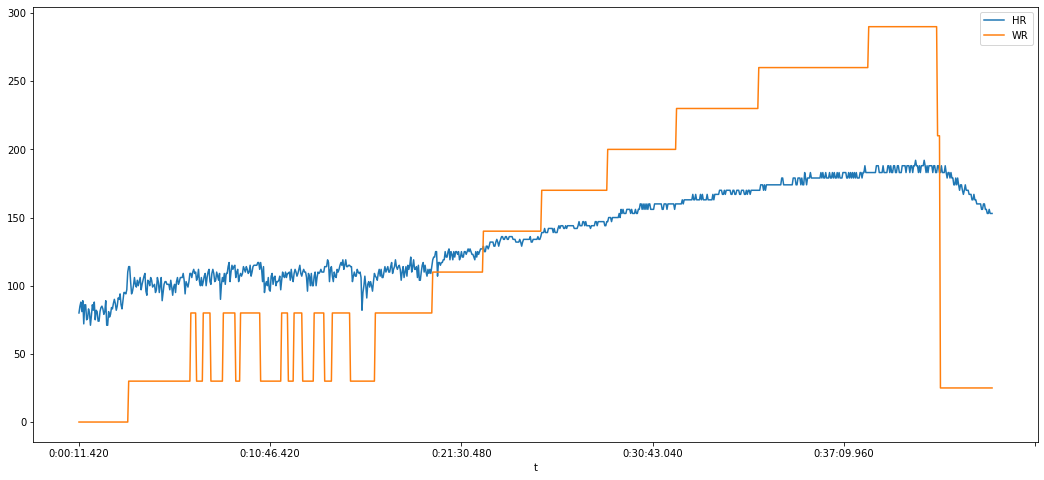

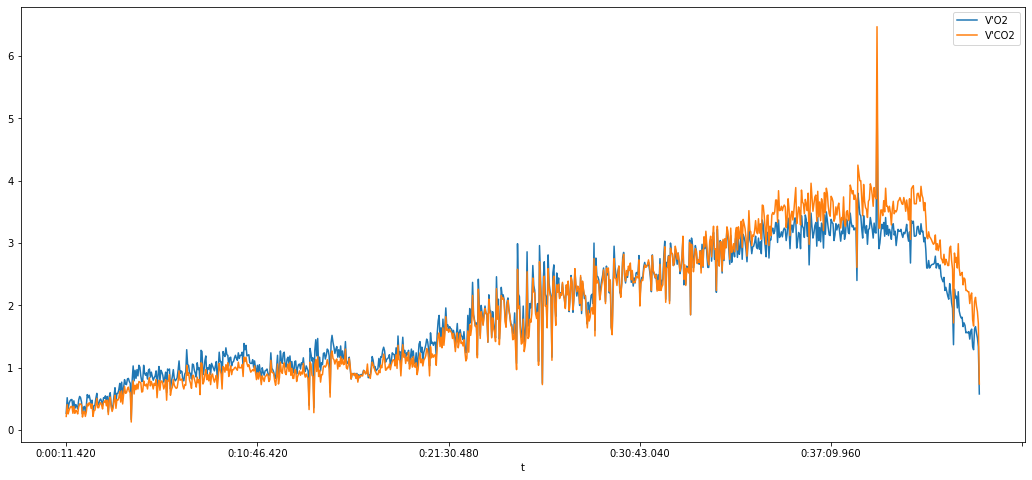

In [4]:
df.plot(x="t",y=["HR","WR"])
df.plot(x="t",y=["V'O2", "V'CO2"])

## Relative $ \dot{V}O_2 $
The absolute $ \dot{V}O_2 $ in our data frame is given in the units $ \frac{L}{min} $. A commonly used measure is the relative VO2, which is expressed in $ \frac{ml}{min*kg} $. We convert from *liter* to *mililiter* and divide by the body weight, which is **93 kg** in our case.

In [5]:
df["VO2rel"]=df["V'O2"]*1000/93

## Get $ \dot{V}O_2peak $ 
There are several ways to obtain the highest value. We want to minimize measurement error but don´t want to loose too much signal by filtering/smoothening. A viable way to obtain $ \dot{V}O_2peak $ is to obtain the highest value from an average of 3 data points. Thus, we smoothen our data with a rolling average over 3 rows and take the maximum:


In [6]:
VO2peak = df["VO2rel"].rolling(3).mean().max()
print(f"VO2peak: {round(VO2peak,1)} ml/min/kg ")

VO2peak: 43.0 ml/min/kg 


## Interpolation
To prepare our dataframe for interpolation, we change the data type of our time column `t` to 'datetime'. Next, we set it as index. Note, that we can´t access `t`anymore directly, but using `df.index()` as you will see later.


In [7]:
df['t']= pd.to_datetime(df['t'])
df=df.set_index('t')

We use several functions in one line of code by using the typcical `.` syntax from Python. The `resample` function first aggregates our data within intervals of `30S` - meaning 30 second - by averaging with the function `mean()`. Note, that `interpolate` is only necessary, if you want to increase your sample rate (upsampling), eg to 1 second intervals. However, this function works fine for both up- and downsampling.

In [10]:
df_sec=df.resample('5S').mean().interpolate('linear')

## Alternative 1
# df_sec=df.set_index('t').resample('30S').mean()

## Alternative 2
#df_sec=df.resample('1S').mean()
#df_sec=df_sec.interpolate('linear')
df.write_csv(df,'yourfile.csv')

,Marker,WR,HR,V'O2,V'CO2,FEetO2,FEetCO2,V'E,VT,BF,RpM,VO2rel
t,,,,,,,,,,,,
2021-05-26 00:00:00,NaN,0.00,84.600000,0.408000,0.314000,15.060000,4.900000,13.300000,0.882000,15.600000,0.000000,4.387097
2021-05-26 00:00:30,NaN,0.00,79.300000,0.430000,0.335000,15.170000,4.760000,15.080000,0.827000,19.000000,0.000000,4.623656
2021-05-26 00:01:00,NaN,0.00,79.428571,0.378571,0.304286,15.242857,4.742857,13.014286,0.881429,17.571429,0.000000,4.070661
2021-05-26 00:01:30,NaN,0.00,81.625000,0.462500,0.371250,15.087500,4.950000,15.387500,0.955000,17.250000,0.000000,4.973118
2021-05-26 00:02:00,NaN,0.00,82.111111,0.462222,0.394444,15.544444,4.855556,16.411111,0.950000,18.222222,0.000000,4.970131
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-26 00:38:00,NaN,290.00,185.037037,3.284444,3.716296,17.214815,4.500000,156.362963,2.789259,56.370370,75.814815,35.316607
2021-05-26 00:38:30,NaN,290.00,186.967742,3.172903,3.646452,17.464516,4.280645,162.490323,2.610968,62.451613,65.290323,34.117239
2021-05-26 00:39:00,NaN,81.25,182.083333,2.702917,3.105833,17.175000,4.595833,130.308333,2.686667,48.750000,35.333333,29.063620


### plot smoothened data

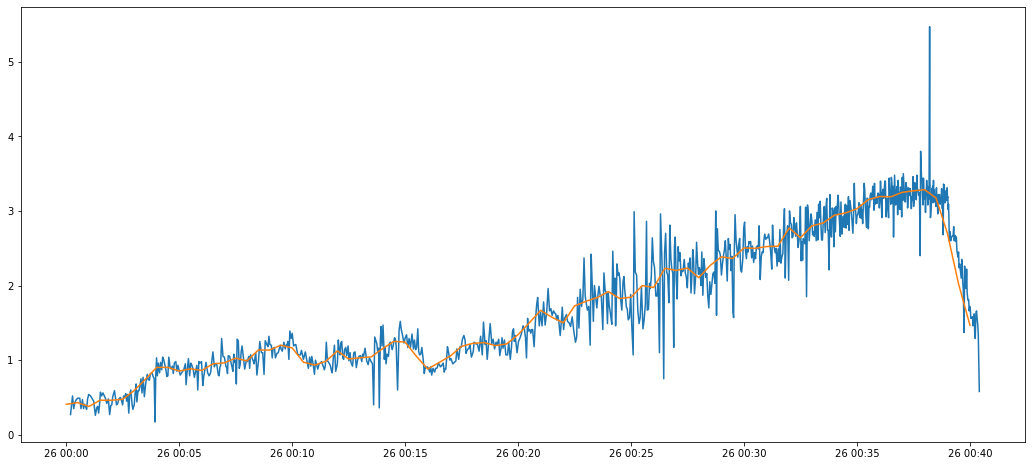

In [11]:
plt.plot(df["V'O2"])
plt.plot(df_sec["V'O2"])

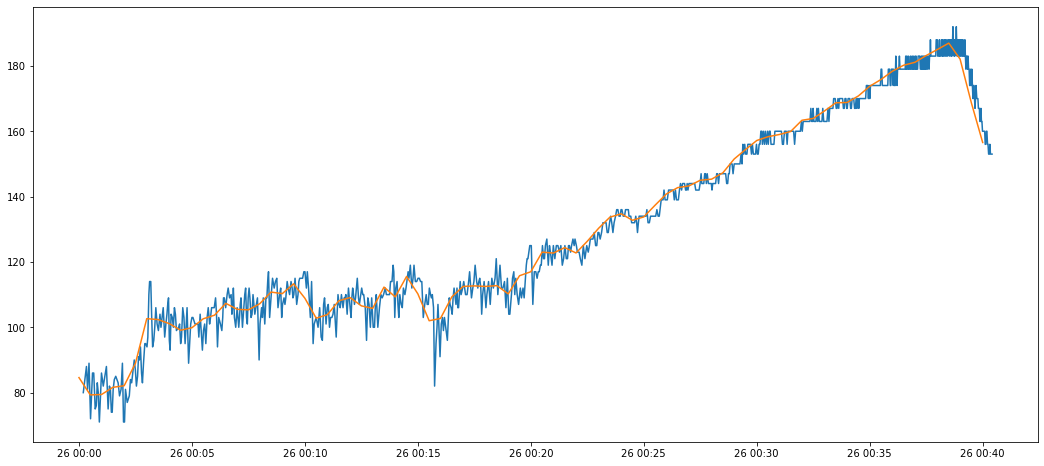

In [12]:
plt.plot(df["HR"])
plt.plot(df_sec["HR"])

## Get stage $ \dot{V}O_2 $
How to get a reliable and valid value for oxygen consumption for each increment? There are two problems: 1) raw data is noisy 2) VO2 seems to increase steadily. This protocol has rather short increments to reach steady-states in oxygen consumption. However, we can derive the most plausible estimates by using the values at the end of each stage. To get an reliable estimate, we use our smoothened dataset `df_sec'.
First, we need to find the time points 


In [13]:
dfstage=df[df.WR.diff()>0]
dfstage=dfstage[dfstage.WR>80]
dfstage

,Phase,Marker,WR,HR,V'O2,V'CO2,FEetO2,FEetCO2,V'E,VT,BF,RpM,VO2rel
t,,,,,,,,,,,,,
2021-05-26 00:19:47.960,Exercise,NaN,110,119,1.42,1.24,14.7,5.7,39.8,1.91,21,65,15.268817
2021-05-26 00:22:48.380,Exercise,NaN,140,129,1.72,1.52,13.8,6.5,39.8,2.27,18,75,18.494624
2021-05-26 00:25:46.180,Exercise,NaN,170,139,1.68,1.50,13.6,6.6,40.0,2.09,19,77,18.064516
2021-05-26 00:28:47.000,Exercise,NaN,200,147,1.60,1.51,15.3,5.7,50.6,1.77,29,76,17.204301
2021-05-26 00:31:45.360,Exercise,NaN,230,160,2.80,2.66,14.6,6.3,72.9,2.58,28,75,30.107527
2021-05-26 00:34:46.480,Exercise,NaN,260,170,2.89,3.08,15.7,5.8,93.7,3.22,29,81,31.075269
2021-05-26 00:37:45.940,Exercise,NaN,290,183,3.24,3.69,17.1,4.6,148.7,2.92,51,74,34.838710


In [14]:
VO2stage=np.interp(dfstage.index, df_sec.index, df_sec["VO2rel"])

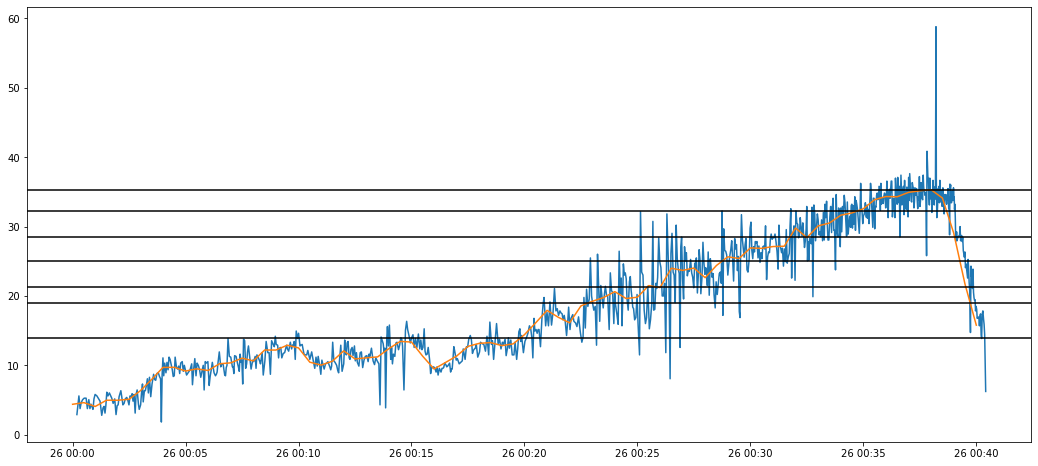

In [15]:
plt.plot(df["VO2rel"])
plt.plot(df_sec["VO2rel"])
for vo2 in VO2stage:
    plt.axhline(vo2, color='k')


## $ \dot{V}O_2 $ to running speed
Hagen et al. (1980) summarized regression formulas to predict the relative oxygen consumption based on the running speed. For example, McMiken & Daniels (1976) gave the following equation:

$$ \dot{V}O_2 [\frac{ml}{kg*min}] = 5.363 + 0.172 * v [\frac{m}{min}] $$

Transposing this formula gives us:

$$  v [\frac{m}{min}] = \frac{\dot{V}O_2 [\frac{ml}{kg*min}] - 5.363}{0.172} $$

Now we plug our observed oxygen consumption for each stage in that formula to predict a corresponding running speed. We further divide by **60** to get from $ \frac{m}{min} $ to $ \frac{m}{s} $:


In [16]:
vstage = (VO2stage - 5.363)/0.172/60

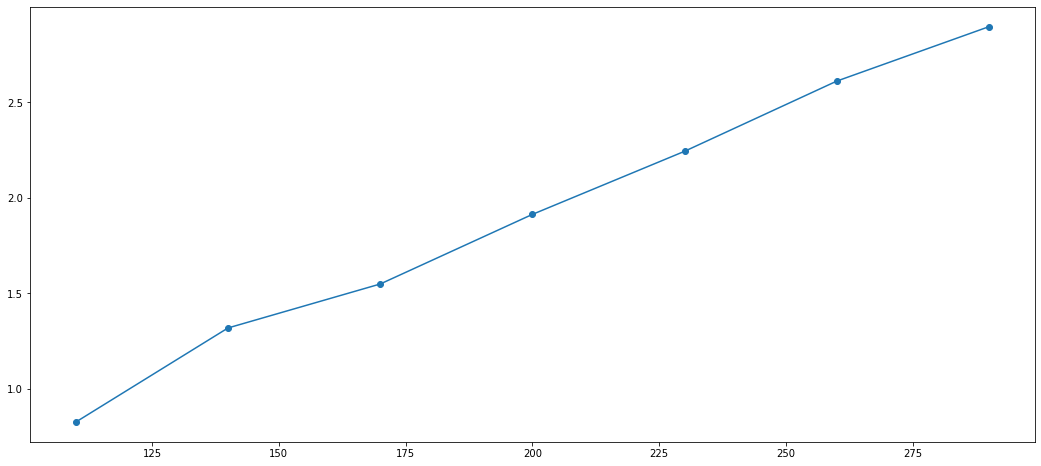

In [17]:
plt.plot(dfstage.WR, vstage,'-o')

## $ \dot{V}O_2 $ prediction on a bike
Graf et al. () proposed absolute oxygen estimates for cycling based on the intensity:

$$ 
(1) \quad \dot{V}O_2 [\frac{ml}{min}] = 3.5 [\frac{ml}{min*kg}] * weight [kg] + 12 * p[W] 
$$

We slightly modify our running equation from above and equal both equations:

$$  
(2) \quad v [\frac{m}{min}] = \frac{\dot{V}O_2 [\frac{ml}{kg*min}] - 5.363}{0.172} 
$$




In [18]:
predVO2 = 3.5 * 93 + 12 * dfstage.WR
predv = (predVO2/93 -5.363) /0.172/60

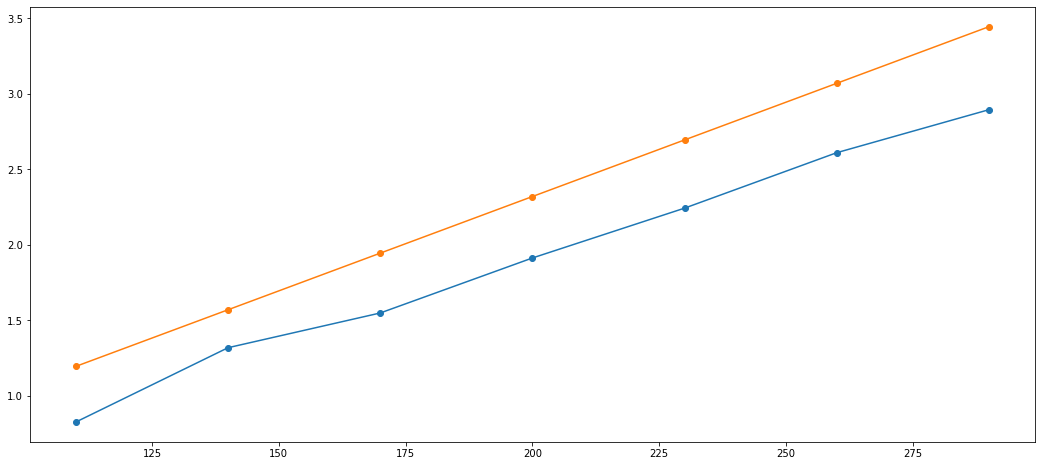

In [19]:
plt.plot(dfstage.WR, vstage,'-o')
plt.plot(dfstage.WR, predv,'-o')